#### Reference
- https://www.youtube.com/watch?v=Q_MbN-vu_2w&t=10s
- https://www.kaggle.com/competitions/bike-sharing-demand/overview/description
- https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile

-----

### Target
- 자전거의 대여량(count)을 예측하는 문제.

### Approach
- Regression approach로 접근하여 estimation.(not a classification)
- 독립변수: count를 제외한 나머지의 parameter의 변수
- 종속변수: count, 즉 대여횟수의 변수

### Data Fields from kaggle
- datetime - hourly date + timestamp  
- season
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as
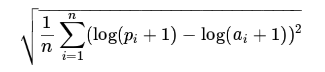

## 1. 필요 라이브러리 import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

---------

## 2. Collecting the data
### train 데이터의 분석 using pandas

In [2]:
df_train = pd.read_csv('./data/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('./data/test.csv')

## 아래처럼 datetime 으로 parameter 이름을 넘겨도 가능.
## df_train = pd.read_csv('./data/train.csv', parse_dates=['datetime'])

---

## [The Sequence of Analaysis]

- Part1: Feature Engineering and Data Cleaning:
    - 1) Adding any few features.
    - 2) Removing redundant features.
    - 3) Converting features into suitable form for modeling.


- Part2: Exploratory Data Analysis(EDA):
    - 1) Analysis of the features.
    - 2) Finding any relations or trends considering multiple features.


- Part3: Predictive Modeling

## Part1
## Feature Engineering and Data Cleaning
- 1) Adding any few features
- 2) Removing redundant features
- 3) Data Cleaning and Null Check
- 4) Converting features into suitable form for modeling

train dataset에서 앞에 5개만 출력해서 확인해 보자.

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Dictionary
- datetime - hourly date + timestamp  
- season
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [4]:
df_train.shape

(10886, 12)

#### Total rows and columns
Training dataset은 10886 rows & 12 columns 으로 구성되어 있다.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Types of Features
- Categorical Features
    - 범주형 변수는 두 개 이상의 범주가 있는 변수이며 해당 기능의 각 값은 범주별로 분류될 수 있다. 
    - 예를 들어, 성별은 두 개의 범주(남성과 여성)가 있는 범주형 변수이다. 
    - 이러한 변수는 정렬하거나 순서를 정할 수 없다. Nominal 변수라고도 한다.

 **Categorical Features in the dataset: season, holiday, workingday, weather**


- Ordinal Features
    - 순서형 변수는 범주형 값과 유사하지만 두 값 사이에 상대적인 순서를 지정하거나 정렬할 수 있다.
    - 예를 들어 높이와 같은 변수에 상대적 정렬을 가질 수 있다.
 
 **Ordinal Features in the dataset:**


- Continous Feature
    - 두 점 사이 또는 최소값 또는 최대값 사이의 값을 취할 수 있는 경우, 이러한 경우 특성을 연속적이라고 한다.

 **Continous Features in the dataset: temp, atemp, humidity, windspeed, casual, registered, count**

### Data Summary
- 데이터의 누락이 없어 보이며, 11개의 columns을 가지고 있다.
- datetime 열에서 **새로운 열** [year,	month, day, hour, minute, second]을 생성한다.
    - 이미 유용한 기능을 추출했으므로 datetime 열을 삭제
- 하지만 season, holiday, workingday and weather는 int 타입이 아닌 **categorical** 이어야 한다.

### 1) Adding any Few Features

#### a. 기존에 있는 datatime열에서 새로운 열 추출
- 새로운 열 추출 후, datetime drop

In [7]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["day"] = df_train["datetime"].dt.day
df_train["hour"] = df_train["datetime"].dt.hour
df_train["minute"] = df_train["datetime"].dt.minute
df_train["second"] = df_train["datetime"].dt.second

df_train = df_train.drop(['datetime'], axis=1)

#### b. Category type으로 변환

In [8]:
categoryVariableList = ['season', 'holiday', 'workingday', 'weather']
for var in categoryVariableList:
    df_train[var] = df_train[var].astype('category')

In [9]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int64   
 12  month       10886 non-null  int64   
 13  day         10886 non-null  int64   
 14  hour        10886 non-null  int64   
 15  minute      10886 non-null  int64   
 16  second      10886 non-null  int64   
dtypes: category(4), float64(3), int64(10)
memory usage: 1.1 MB


### 2) Removing redundant features

In [11]:
print(df_train['hour'].unique())
print(df_train['minute'].unique())
print(df_train['second'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[0]
[0]


- [minute] / [second] 에 데이터가 모두 0이기에 삭제

In [12]:
df_train = df_train.drop(['minute'], axis=1)
df_train = df_train.drop(['second'], axis=1)

In [13]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


### 3) Data Cleaning and Null Check
- 데이터와 열에 익숙해지면 다음 단계는 일반적으로 데이터에 누락된 값이 있는지 확인
- 일반적으로 데이터 세트에서 누락된 값을 시각화하는 것을 선호하는 한 가지 방법은 "missingno"를 사용

<AxesSubplot:>

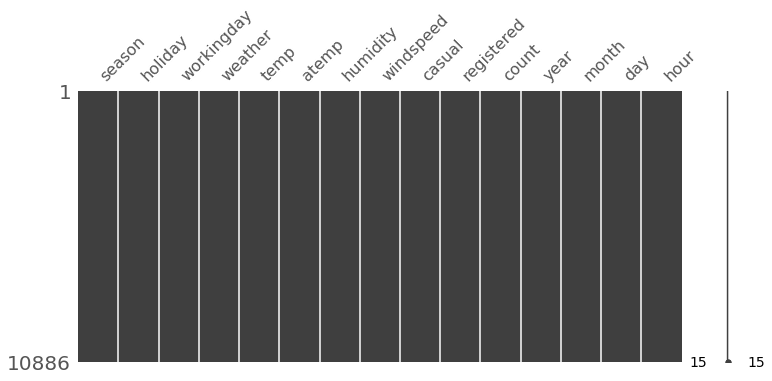

In [14]:
import missingno as msno
msno.matrix(df_train, figsize=(12,5))

## Part2
## Exploratory Data Analysis(EDA)
- 1) Analysis of the features.
- 2) Finding any relations or trends considering multiple features.

### 1) Analysis of the Features
- Target Analysis

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

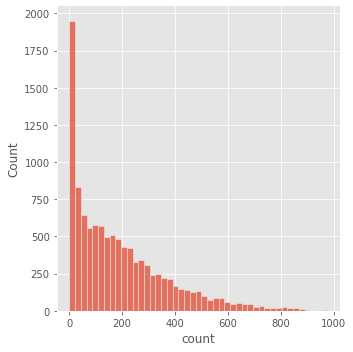

In [15]:
sns.displot(df_train['count'])
df_train['count'].describe()

<AxesSubplot:xlabel='count', ylabel='Density'>

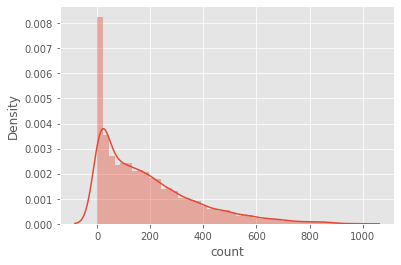

In [16]:
sns.distplot(df_train['count'])

### 1) Analysing The Features
#### Bar Chart for Categorical Features
- season
- holiday
- workingday
- weather
- temp
- atemp
- humidity
- windspeed
- casual
- registered

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'Hour Demand')]

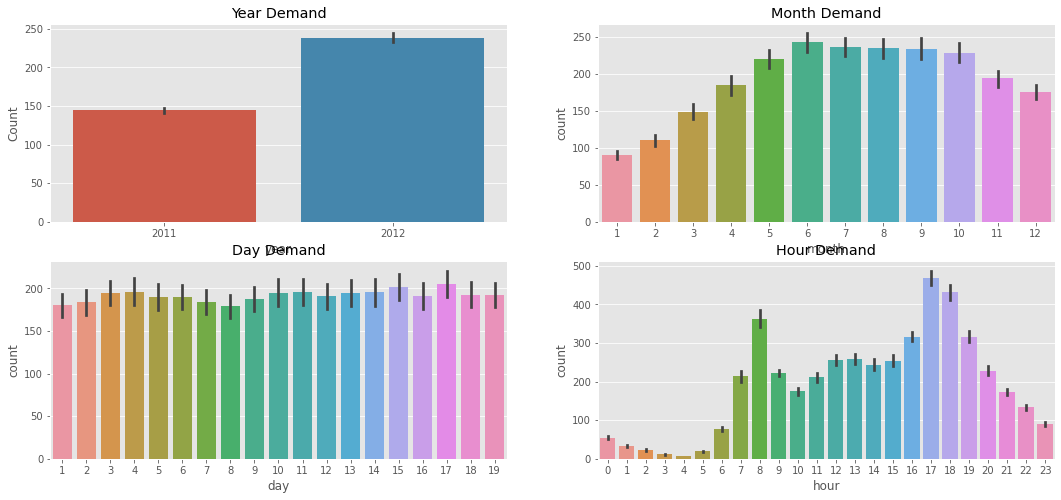

In [21]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,8)

sns.barplot(data=df_train, x="year", y="count", ax=ax1)
sns.barplot(data=df_train, x="month", y="count", ax=ax2)
sns.barplot(data=df_train, x="day", y="count", ax=ax3)
sns.barplot(data=df_train, x="hour", y="count", ax=ax4)

ax1.set(ylabel='Count',title="Year Demand")
ax2.set(xlabel='month',title="Month Demand")
ax3.set(xlabel='day', title="Day Demand")
ax4.set(xlabel='hour', title="Hour Demand")

- Year Demand
    - 2012년이 2011년보다 대여량이 많다.

### a. Python lib for visualization